In [1]:
### from typing import Union

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data, flatten
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.ds.challenge_dataset import load_challenge_data
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.model.sliding_attention_classifier import SlidingAttentionClassifier, SlidingAttentionClassifierHyperParameters
from lib.torch_generic_model_training import train_model_with_cv
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch, calculate_average_metrics
from lib.ds.bird_combiner import combine_birds
from lib.challenge import predict_for_challenge, save_results_to_csv, load_results_from_csv
from lib.label_fixing import fix_labels_information_gain
import lib.torch_device as tdev

%load_ext autoreload
%autoreload 2

In [2]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [3]:
data_raw, labels = load_all_data('dataset')
print(f'{data_raw.shape = }')
print(f'{labels.shape   = }')

data_raw.shape = (1200, 100, 548)
labels.shape   = (1200, 100)


In [4]:
dataset_raw_train, dataset_raw_test = split(NumpyDataset(data_raw, labels), test_size_pct=0.2, seed=69420666)


print(f'{dataset_raw_train.data.shape = }')
print(f'{dataset_raw_test.data.shape  = }' if dataset_raw_test is not None else 'dataset_raw_test             = None')

dataset_raw_train.data.shape = (960, 100, 548)
dataset_raw_test.data.shape  = (240, 100, 548)


### Create sequences

In [5]:
sequences_ds_train = combine_birds(
    dataset_raw_train, 
    sequence_length=300,
    random_seed=42
)
print(f'{sequences_ds_train.data.shape   = }')
print(f'{sequences_ds_train.labels.shape = }\n\n')


sequences_ds_test = combine_birds(
    dataset_raw_test, 
    sequence_length=300,
    random_seed=42
)

if sequences_ds_test is not None:
    print(f'{sequences_ds_test.data.shape   = }')
    print(f'{sequences_ds_test.labels.shape = }')
else:
    print('sequences_ds_test = None')

Creating random sequence (num_duplicates = 1): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96000/96000 [01:20<00:00, 1193.84it/s]


sequences_ds_train.data.shape   = (320, 300, 548)
sequences_ds_train.labels.shape = (320, 300)




Creating random sequence (num_duplicates = 1): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24000/24000 [00:05<00:00, 4774.64it/s]

sequences_ds_test.data.shape   = (80, 300, 548)
sequences_ds_test.labels.shape = (80, 300)


# Hyper Parameters

In [11]:
ac_hyper_parameters = SlidingAttentionClassifierHyperParameters(
    in_features=data_raw.shape[-1],
    out_features=NUM_CLASSES,
    
    attention_window_size=25,
    step=5,
    
    d_model=64,
    num_heads=16,
    attention_stack_size=2,
    attention_stack_activation_provider=lambda: nn.LeakyReLU(),
    attention_dropout=0.5,
    
    in_linear_hidden_out_features=[48, 48],
    out_linear_hidden_out_features=[32, 16],
    linear_activation_provider=lambda: nn.LeakyReLU(),
    linear_dropout=0.45,
)

In [18]:
training_hyper_parameters = TrainingHyperParameters(
        batch_size=17,
        
        loss_weight_modifiers=torch.Tensor([
            1.0 / 3, # 0
            1.0, # 1
            1.0 / 0.5, # 2
            1.0 / 0.5, # 3
            1.0, # 4
            1.0, # 5
            1.0, # 6
        ]),
        
        optimizer_provider=lambda model, lr: optim.Adamax(
            model.parameters(),
            lr=lr,
            betas=(0.9, 0.98),
            eps=1e-9,
            weight_decay=1e-4
        ),

        num_epochs=150,
        lr=1e-2,
    
        lr_scheduler_milestones=[int(m) for m in [30, 100, 250]],
        lr_scheduler_gamma=0.75,
        lr_scheduler_provider=lambda optimizer, milestones, gamma: None,
        # lr_scheduler_provider=lambda optimizer, milestones, gamma: lr_scheduler.MultiStepLR(
        #     optimizer, 
        #     milestones=milestones,
        #     gamma=gamma
        # )
    )

# Training

## Cross Validation

Creating 8 folds


CV Folds:   0%|                                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]




Executing CV for fold 0
Training fold 0


#### Training ####
##################
SlidingAttentionClassifier with 67847 parameters, in_fnn: 31840, attention_stack: 33280, out_fnn: 2727
##################

train label counts = [60099,  4234,  5949,  5557,  1577,  3804,  2780]
eval label counts  = [ 8493,   513,  1012,   872,   220,   374,   516]

loss weights                    = [ 0.50, 14.19, 20.20, 21.63, 38.11, 15.80, 21.62]
eval loss weights (theoretical) = [ 0.50, 16.56, 16.78, 19.48, 38.60, 22.71, 16.46]


Training Epoch   1/150: lr = 1.00E-02, epoch =     1, avg_loss = 0.000358, num_samples = 84000, num_correct =  6648, acc = 0.079143, bacc = 0.139345, score = -0.396392
Evaluation Epoch   1/150: epoch =     1, avg_loss = 0.000552, num_samples = 12000, num_correct =  1012, acc = 0.084333, bacc = 0.142857, score = -0.364198
Training Epoch   2/150: lr = 1.00E-02, epoch =     2, avg_loss = 0.000289, num_samples = 84000, num_correct =  7524, acc = 0.089571, bacc = 0.241431, score = 

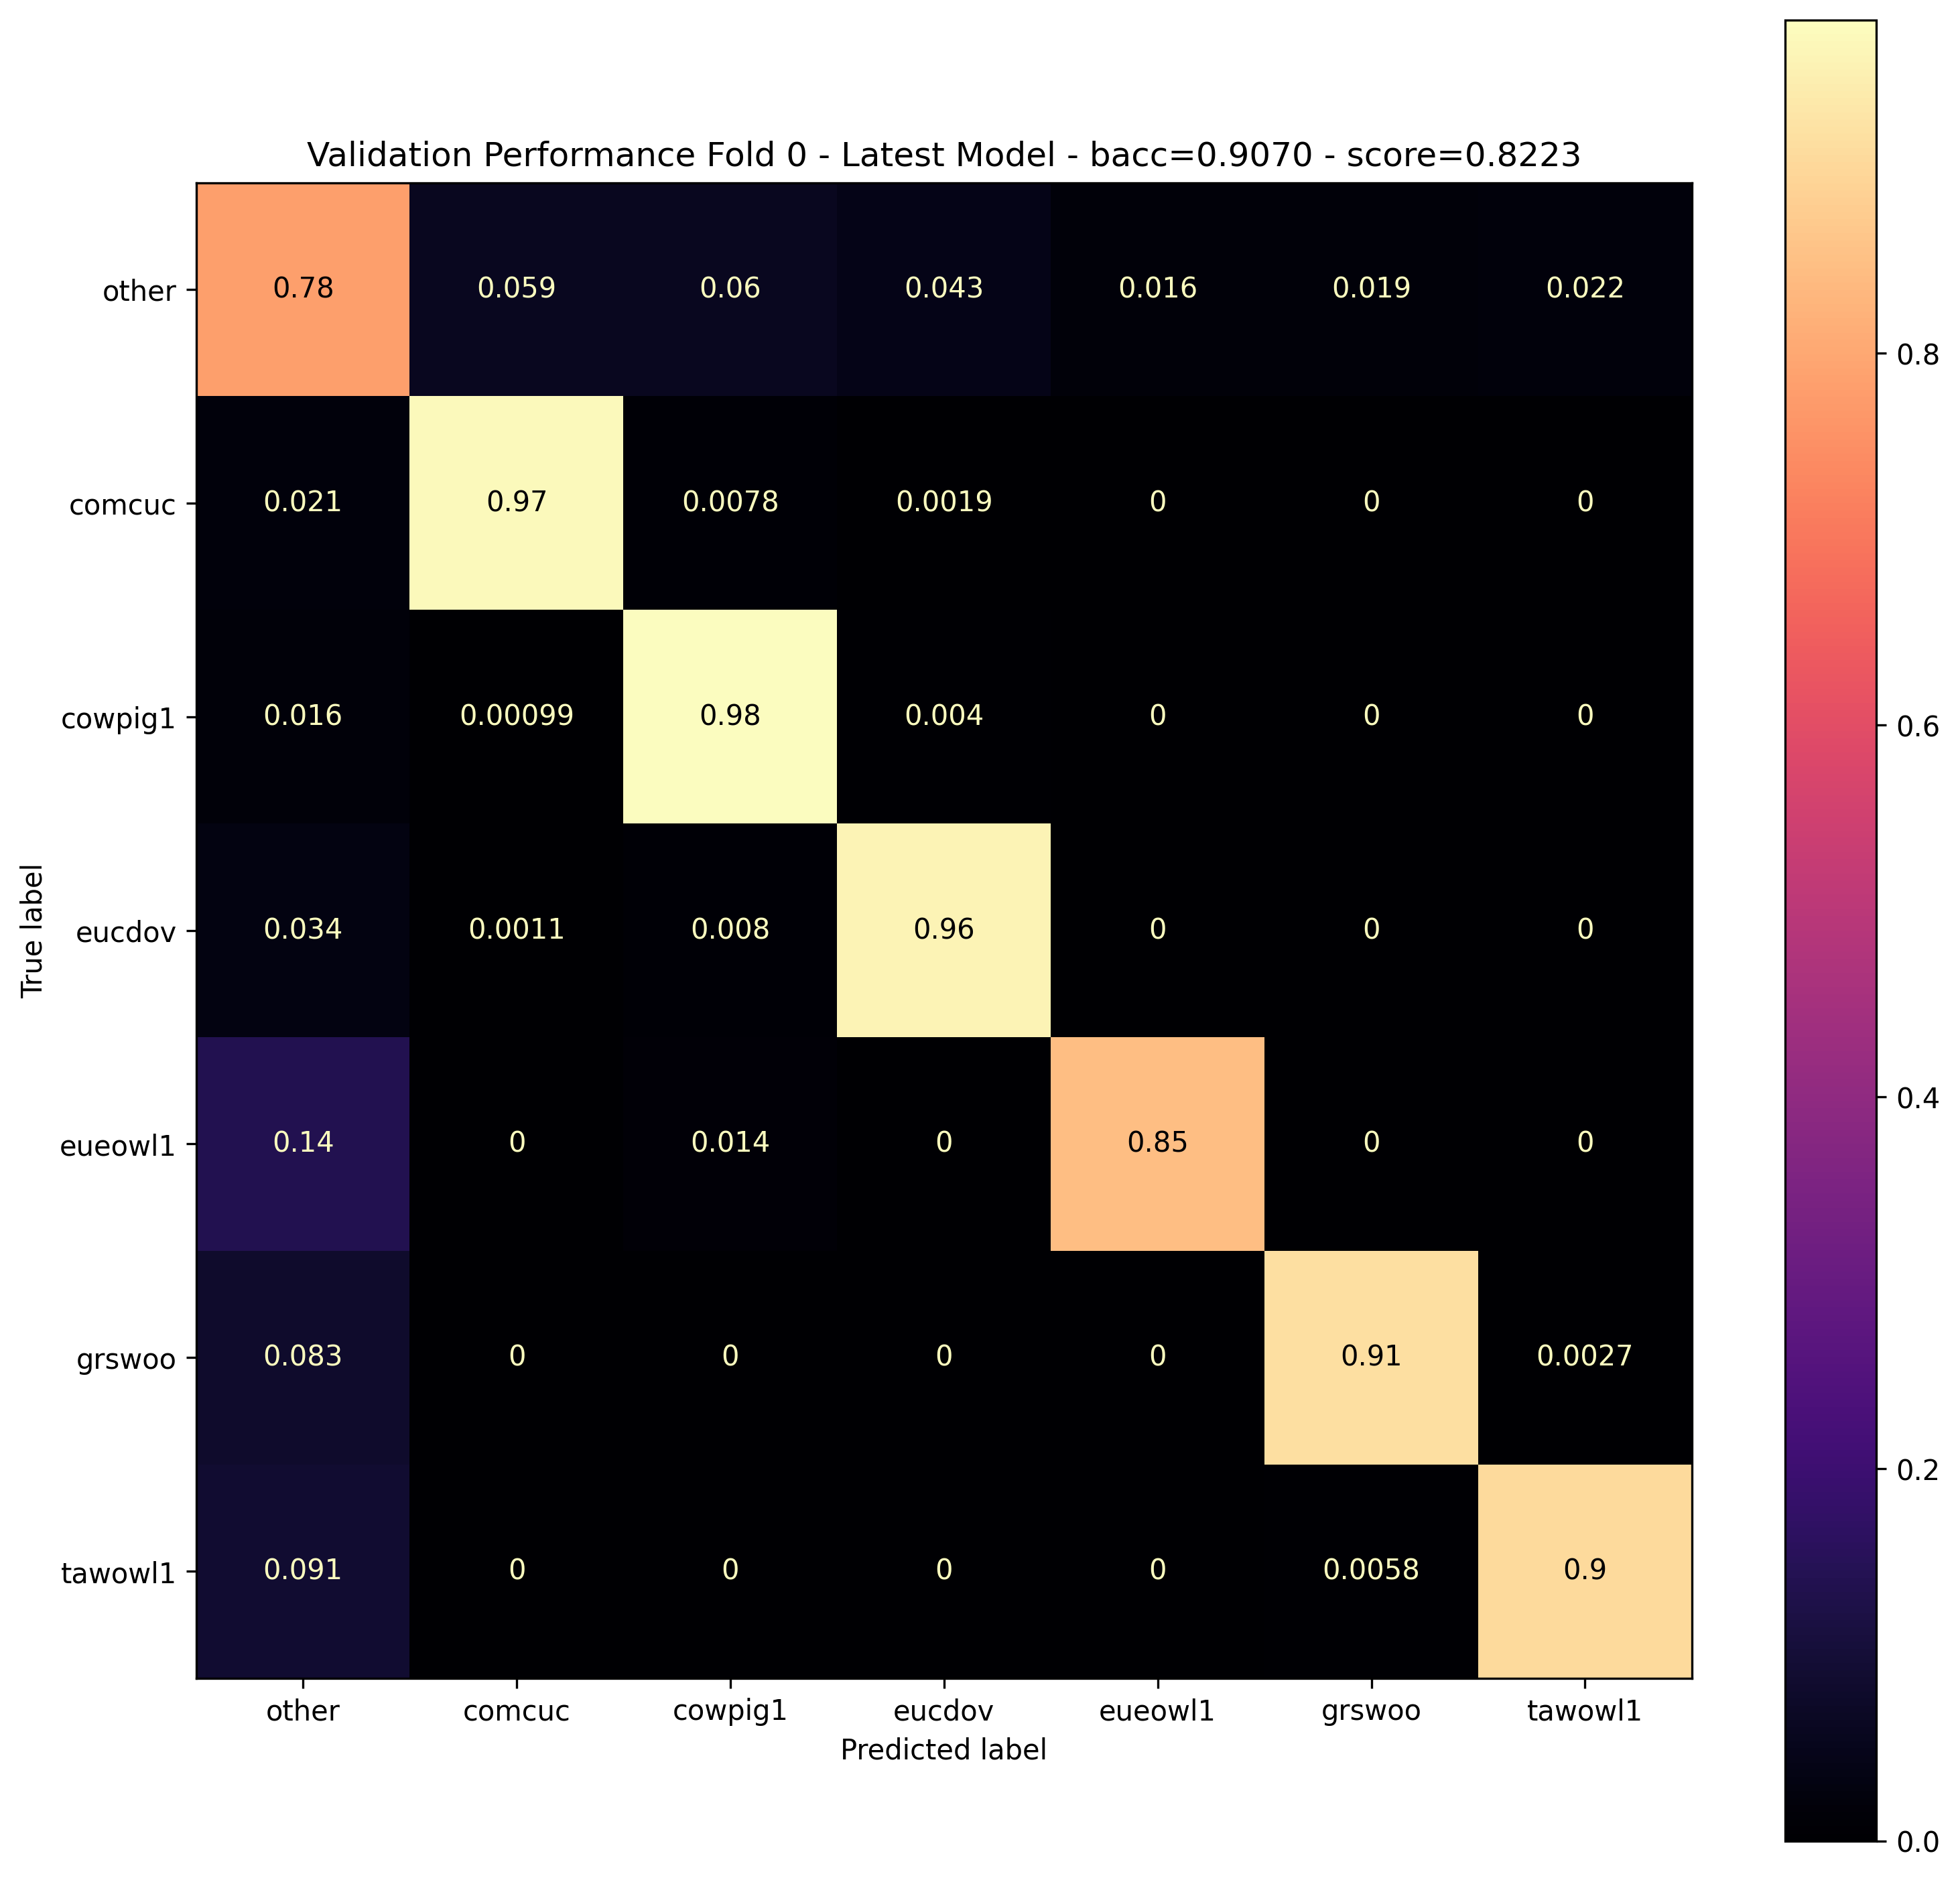

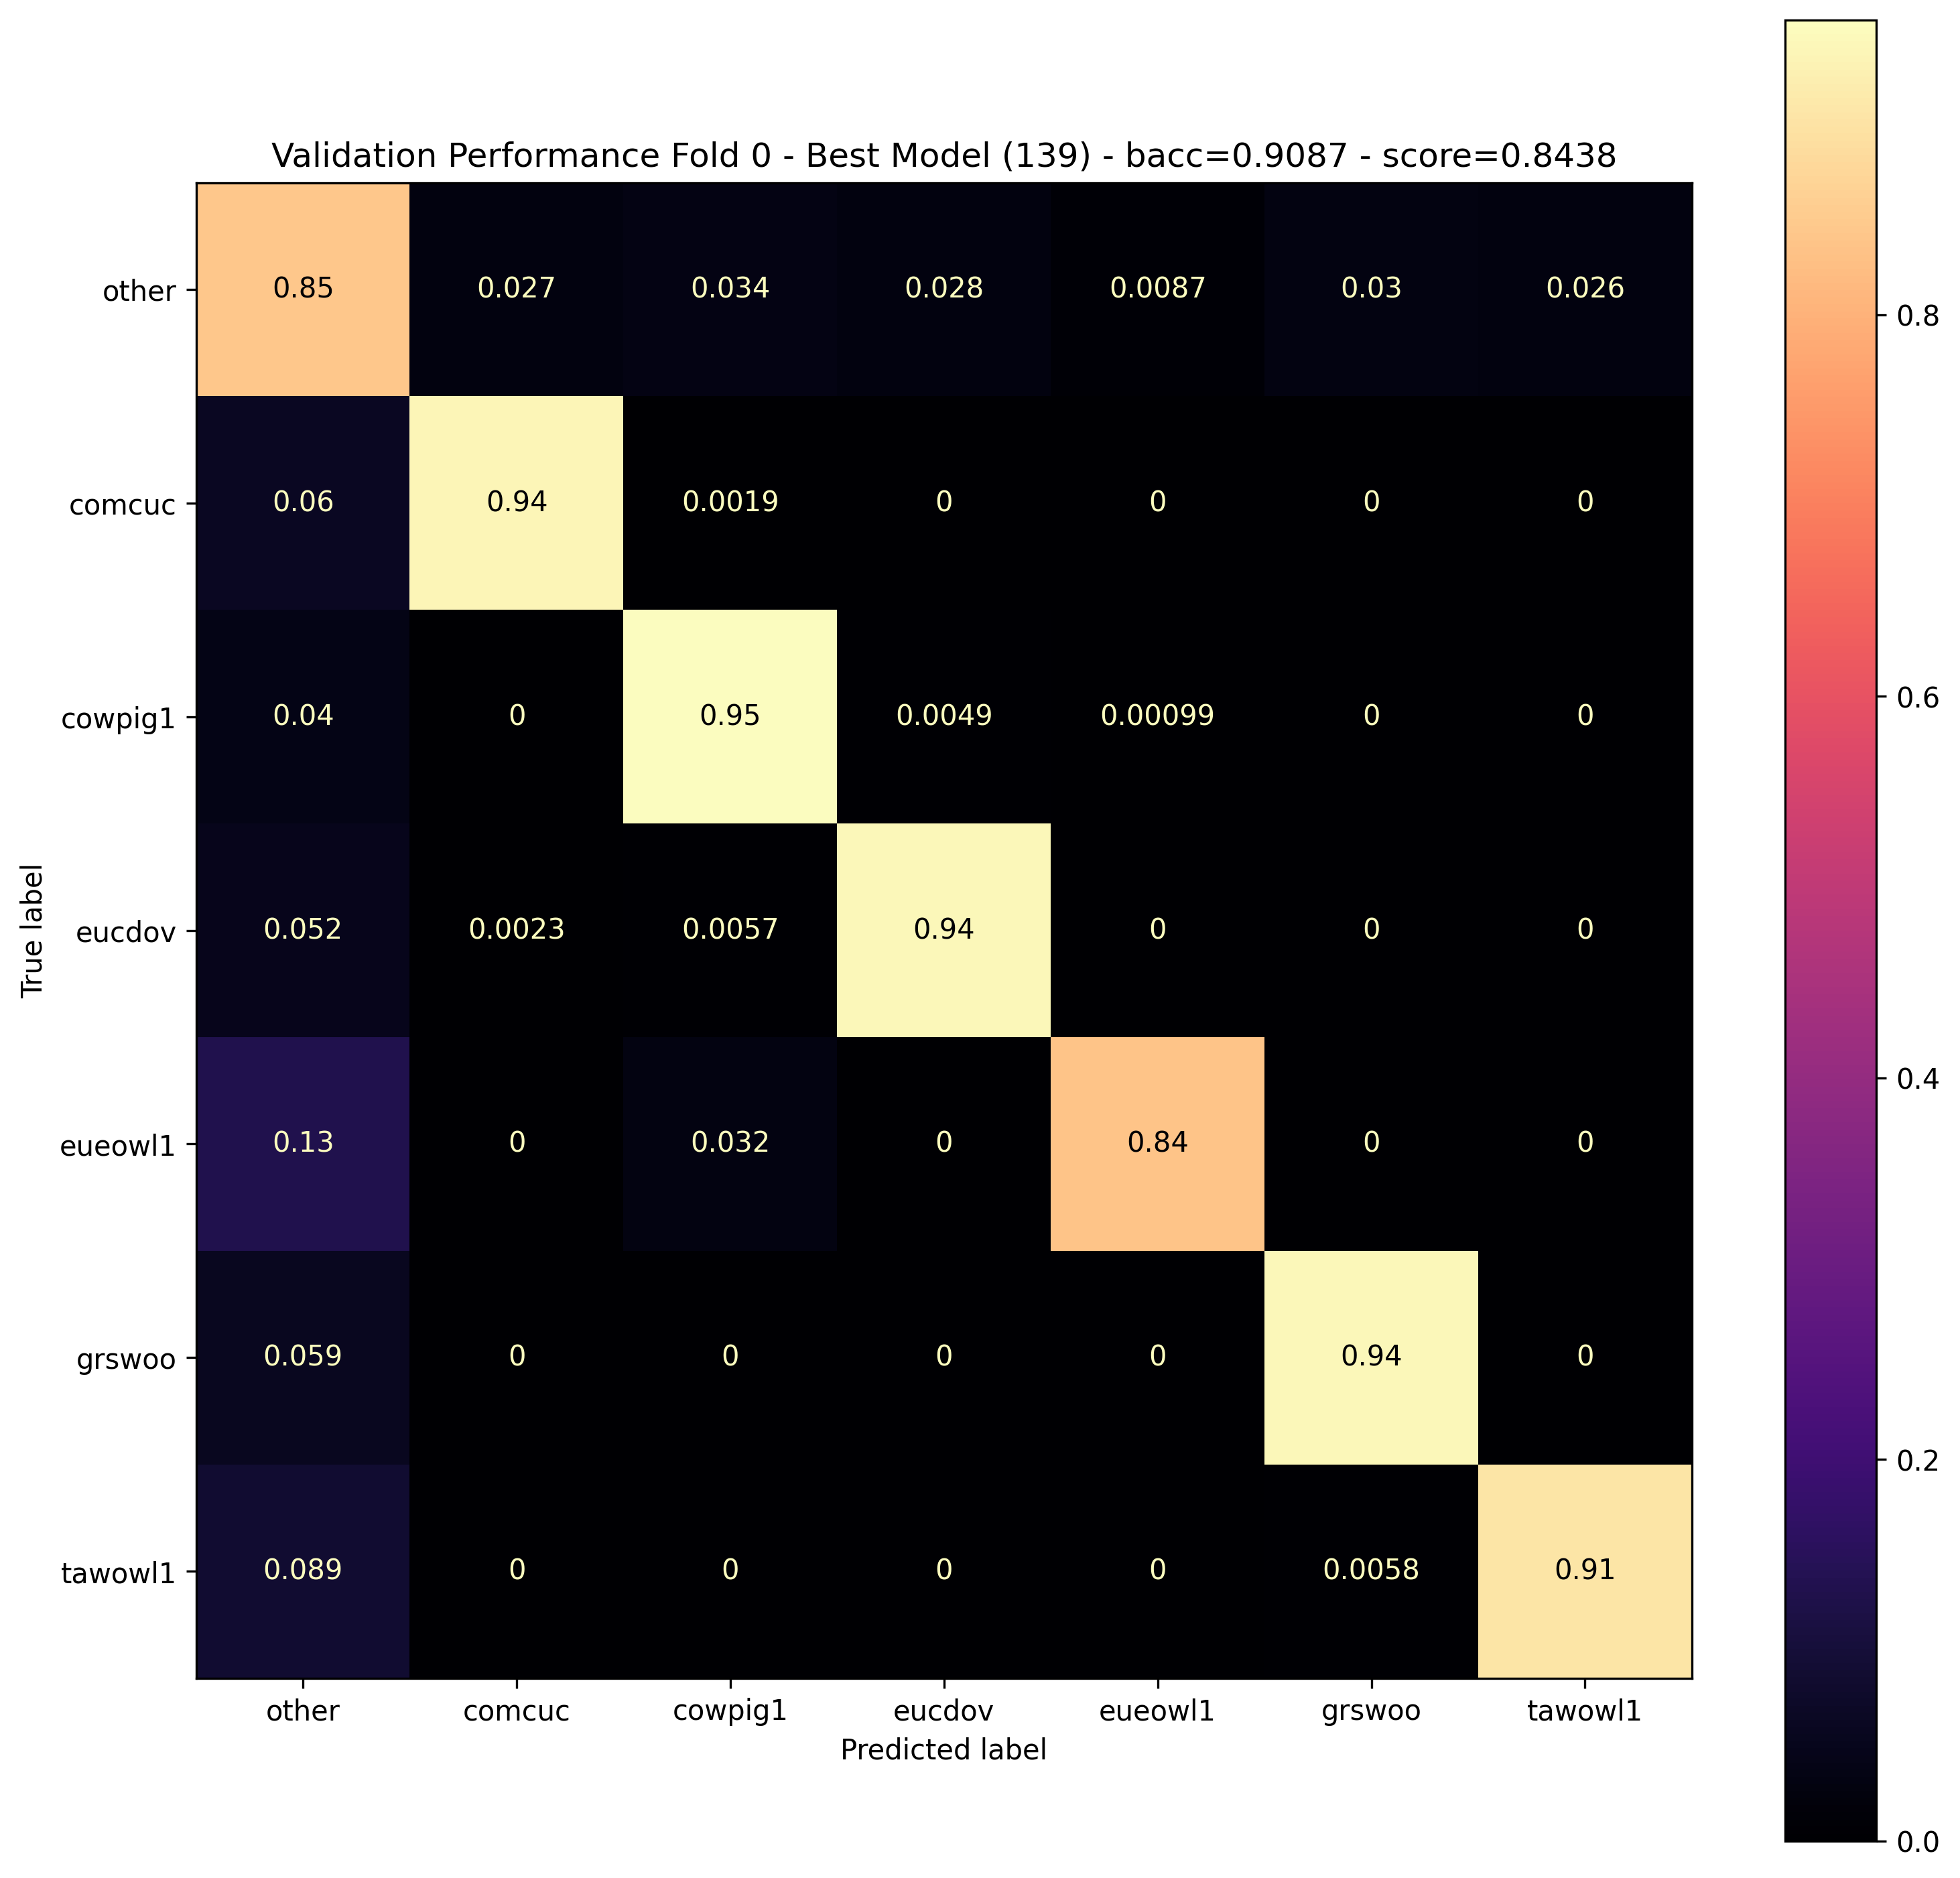


Testing fold 0


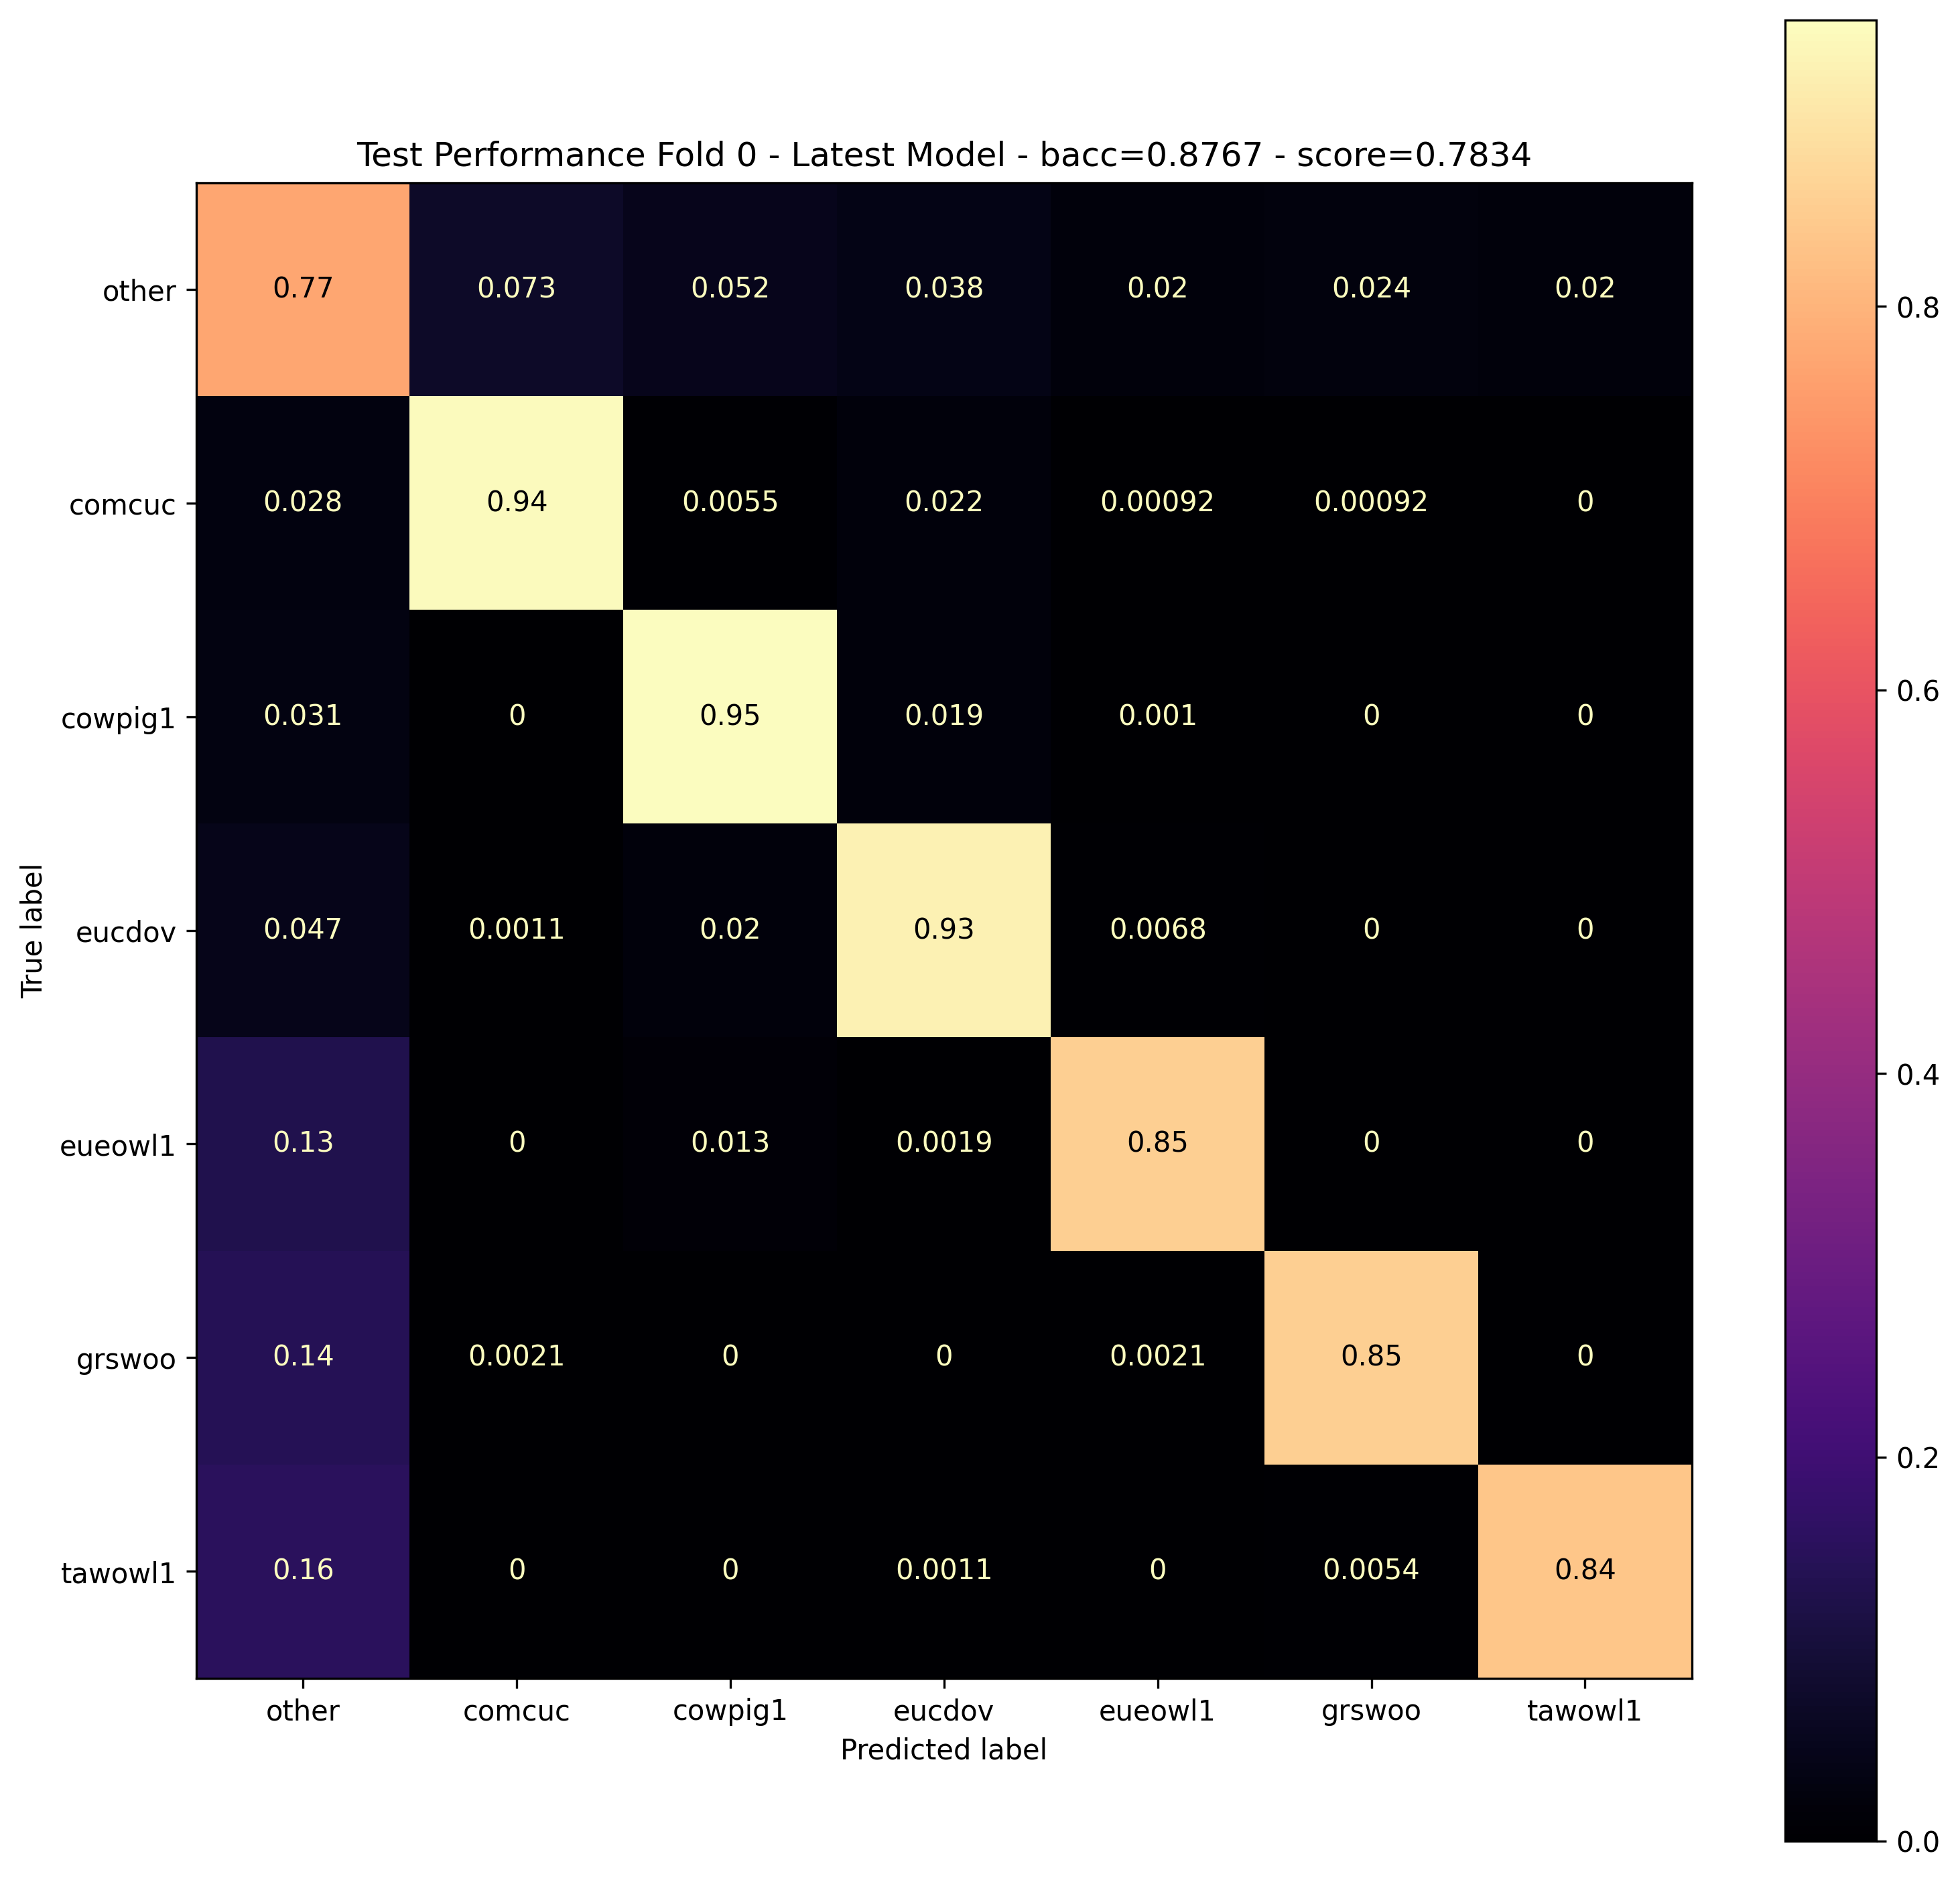

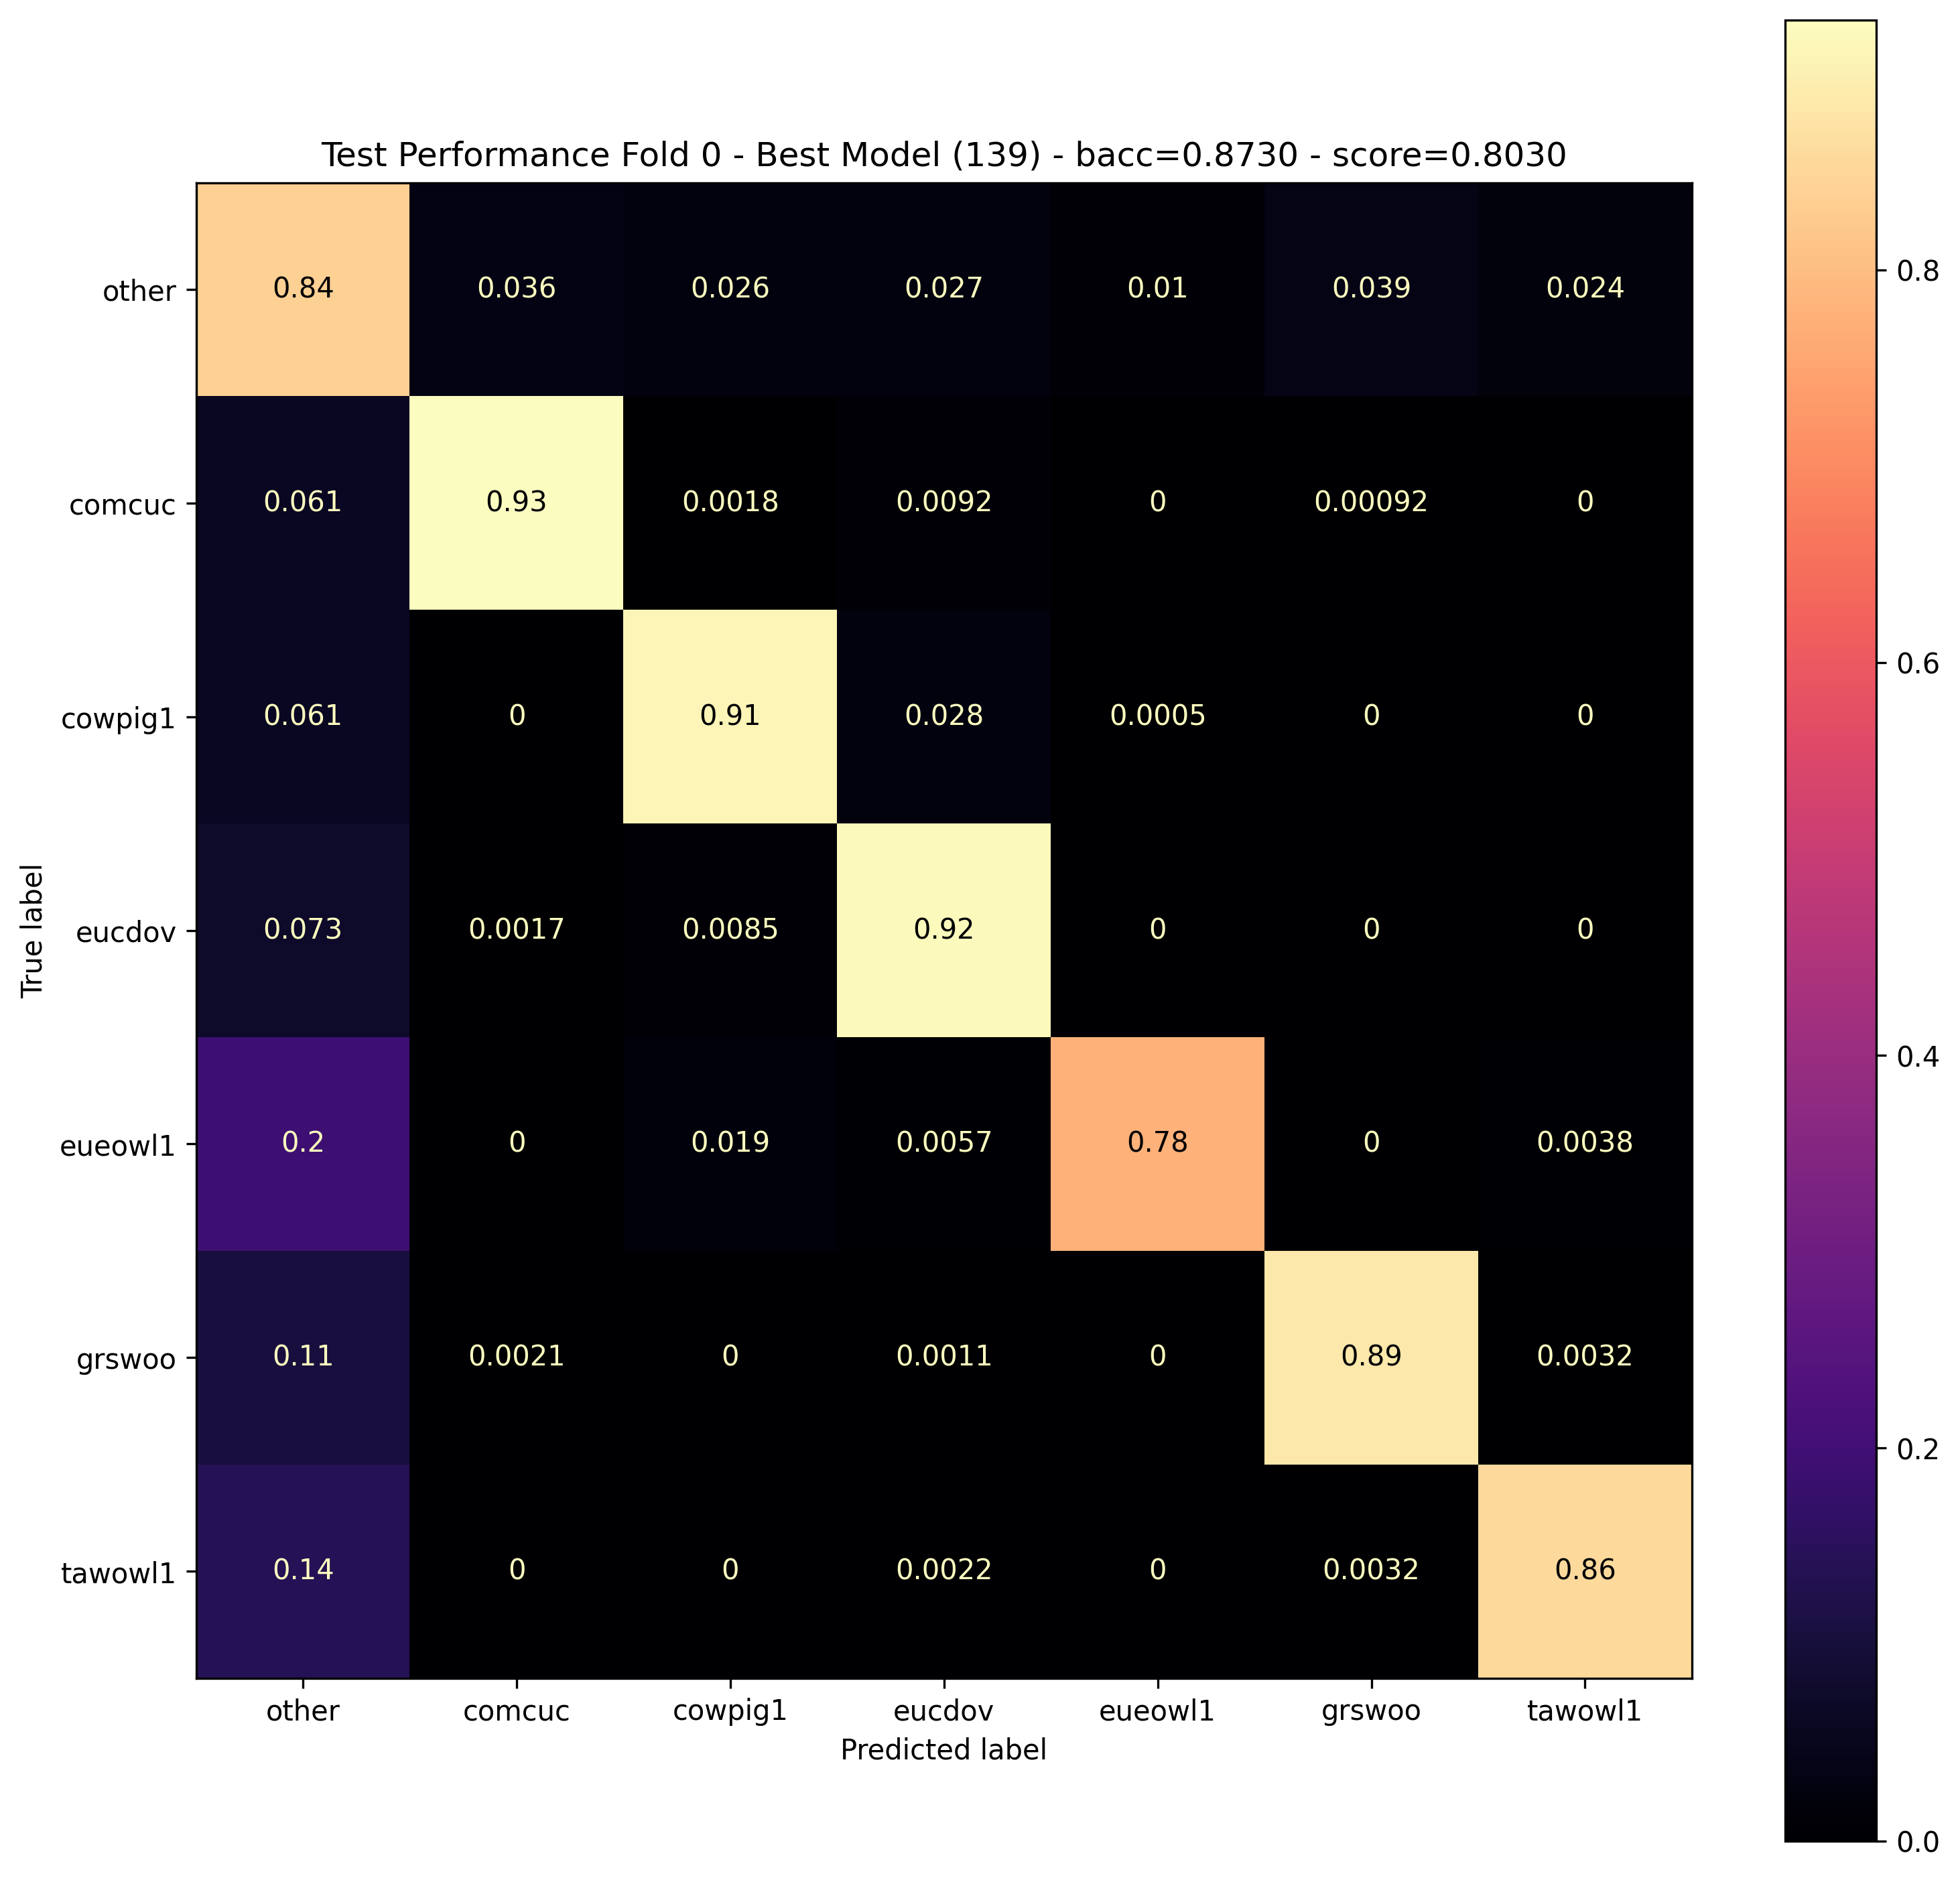

CV Folds:   0%|                                                                                                                                                                                                                     | 0/8 [01:32<?, ?it/s]

Best Model Test Metrics: epoch =    -1, avg_loss = 0.000115, num_samples = 24000, num_correct = 20530, acc = 0.855417, bacc = 0.873014, score = 0.803034


PicklingError: Can't pickle <class 'lib.model.sliding_attention_classifier.SlidingAttentionClassifier'>: it's not the same object as lib.model.sliding_attention_classifier.SlidingAttentionClassifier

In [19]:
set_random_seed(43)

cv_models_with_scalers, cv_folds_metrics, best_models_metrics = train_model_with_cv(
    lambda: SlidingAttentionClassifier(ac_hyper_parameters, batch_first=True),
    training_hyper_parameters, 
    sequences_ds_train,
    sequences_ds_test,
    n_folds=8,
    device=device,
    save_models='best',
    model_saving_name='species_classifier',
)


## Metrics ##
print(
'''

#################
#### Metrics ####
#################

'''
)

cv_average_best_best_models_eval_metrics = calculate_average_metrics([m[1] for m in best_models_metrics])
print(f'{cv_average_best_best_models_eval_metrics = } \n\n')

if best_models_metrics[0][2] is not None:
    cv_average_best_best_models_test_metrics = calculate_average_metrics([m[2] for m in best_models_metrics])
    print(f'{cv_average_best_best_models_test_metrics = } \n\n')

cv_avg_epoch_train_metrics = calculate_average_metrics_per_epoch(cv_folds_metrics)

rows = []
for fold_nr, fold_metrics in enumerate(cv_folds_metrics):
    for epoch_nr, (train_metrics, eval_metrics) in enumerate(fold_metrics):
        rows.append({
            'cv_fold': fold_nr,
            'epoch': epoch_nr,
            'type': 'CV Train BACC',
            'bacc': train_metrics.bacc,
        })
        if eval_metrics is not None:
            rows.append({
                'cv_fold': fold_nr,
                'epoch': epoch_nr,
                'type': 'CV Eval BACC',
                'bacc': eval_metrics.bacc,
            })

cv_metrics_df = pd.DataFrame(rows)

# Plots

In [ ]:
def create_lrs_over_epochs(training_hyper_parameters: TrainingHyperParameters) -> list[float]:
    lrs: list[float] = []
    
    lr = training_hyper_parameters.lr
    for epoch_nr in range(training_hyper_parameters.num_epochs):
        if epoch_nr in training_hyper_parameters.lr_scheduler_milestones:
            lr *= training_hyper_parameters.lr_scheduler_gamma
        lrs.append(lr)
    return lrs
    

def plot_baccs_over_epochs(title: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
    
    cv_epoch_range = np.arange(0, training_hyper_parameters.num_epochs)
    
    sns.lineplot(data=cv_metrics_df, x='epoch', y='bacc', hue='type', ax=ax, palette=['blue', 'green'])
    
    twin_ax = ax.twinx()
    lr_plots_kwargs = {
        'ls': '--',
        'lw': 0.75
    }
    twin_ax.plot(cv_epoch_range, create_lrs_over_epochs(training_hyper_parameters), label='CV LR', c='lightblue', **lr_plots_kwargs)

    ax.set(
        title=title,
        xlabel='Epoch',
        ylabel='BACC',
        yticks=[x * 0.1 for x in range(11)]
    )

    ax.grid(ls=':')
    ax.legend(loc='center right')
    twin_ax.legend(loc='lower right')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
        twin_ax.spines[spine].set_visible(False)

    plt.show()

average_last_epoch_eval_bacc = cv_metrics_df.query('type == "CV Eval BACC"').groupby('epoch').mean().iloc[-1]['bacc']
plot_baccs_over_epochs(f'Attention Classifier, last epoch eval bacc = {average_last_epoch_eval_bacc:6f}')